In [1]:
import sys
import glob
import cv2
import numpy as np
import os

from shutil import copytree
from shutil import rmtree



import pickle
import math, re
from os import path

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adamax, RMSprop
import matplotlib.pyplot as plt

import pandas as pd
import random
import shutil
import pathlib

## **Data preparation**

In this cell you're going to:
1.   Read images
2.   Preprocess them
3.   Create labels from the dirs.

Don't forget to create test, val and train sets

Split them appropriately

If you want to use **ImageDataGenerator** please write your final dataset in a directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/dataset.zip

Archive:  drive/MyDrive/dataset.zip
   creating: dataset/
   creating: dataset/mazda_3/
  inflating: dataset/mazda_3/1.jpg   
  inflating: dataset/mazda_3/2.jpg   
  inflating: dataset/mazda_3/3.jpg   
  inflating: dataset/mazda_3/4.jpg   
  inflating: dataset/mazda_3/5.jpg   
  inflating: dataset/mazda_3/6.jpg   
  inflating: dataset/mazda_3/7.jpg   
  inflating: dataset/mazda_3/8.jpg   
  inflating: dataset/mazda_3/9.jpg   
  inflating: dataset/mazda_3/10.jpg  
  inflating: dataset/mazda_3/11.jpg  
  inflating: dataset/mazda_3/12.jpg  
  inflating: dataset/mazda_3/13.jpg  
  inflating: dataset/mazda_3/14.jpg  
  inflating: dataset/mazda_3/15.jpg  
  inflating: dataset/mazda_3/16.jpg  
  inflating: dataset/mazda_3/17.jpg  
  inflating: dataset/mazda_3/18.jpg  
  inflating: dataset/mazda_3/19.jpg  
  inflating: dataset/mazda_3/20.jpg  
  inflating: dataset/mazda_3/21.jpg  
  inflating: dataset/mazda_3/22.jpg  
  inflating: dataset/mazda_3/23.jpg  
  inflating: dataset/mazda_3/24.jpg  


In [4]:
#####################################
##### Your implementation here ######

classes = ['iranKhodro_dena', 'kia_cerato', 'mazda_3', 'peugeot_206', 'saipa_saina']

train_dir = './train'
os.mkdir(train_dir)
test_dir = './test'
os.mkdir(test_dir)
val_dir = './val'
os.mkdir(val_dir)

train_split = 0.8
test_split = 0.1
val_split = 0.1
for c in classes:
    os.mkdir(os.path.join(train_dir, c))
    os.mkdir(os.path.join(test_dir, c))
    os.mkdir(os.path.join(val_dir, c))
    files = glob.glob(f'dataset/{c}/*')
    total = len(files)
    random.shuffle(files)
    for i in glob.glob(f'dataset/{c}/*')[:int(train_split * total)]:
        shutil.copyfile(i, i.replace(f'dataset/{c}/', f'train/{c}/{c}_'))
    for i in glob.glob(f'dataset/{c}/*')[int(train_split * total):int((1 - test_split) * total)]:
        shutil.copyfile(i, i.replace(f'dataset/{c}/', f'test/{c}/{c}_'))
    for i in glob.glob(f'dataset/{c}/*')[int((1 - test_split) * total):]:
        shutil.copyfile(i, i.replace(f'dataset/{c}/', f'val/{c}/{c}_'))
#####################################

## **Define global variable**

Feel free to change them

In [5]:
num_classes = 5
EPOCHS = 100
BATCH_SIZE = 20

BASE_FOLDER = './data/'

## **Create your own CNN model**

In [6]:
def create_cnn_model():
    '''
    In this function you should create your CNN model and define layers
    via Sequential or Functional API

    Feel free to set hyperparameters of model as you desired

    Then compile your model and define optimizer ans loss function

    Please set your metrices to monitor the accuracy

    At the end of the code please print the summary of the model

    Arguments:
    output: created model
    '''
    #####################################
    ##### Your implementation here ######

    model = Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPool2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPool2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', strides=2))
    model.add(layers.MaxPool2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    #####################################

    return model

In [7]:
def create_callbacks():
    '''
    We prefer use three of the callbacks in the keras API

    1. early stopping: take a look at https://keras.io/api/callbacks/early_stopping/
    2. reduce_lr: take a look at https://keras.io/api/callbacks/reduce_lr_on_plateau/
    3. model_checkpoints: take a look at https://keras.io/api/callbacks/model_checkpoint/

    Arguments:
    output: a list of callbacks

    '''
    #####################################
    ##### Your implementation here ######

    early_stopping = EarlyStopping(monitor='loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoints = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    callbacks = [early_stopping, reduce_lr, model_checkpoints]


    #####################################

    return callbacks

In [8]:
def train_model_naive_split():
    '''
    We need to first read our stored data then fit our created model with provided callbacks

    For this use the https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator function

    You can load your data in a way you feel comfortable and there is no force to use this methods

    outputs: The History of the training process
    '''
    #####################################
    ##### Your implementation here ######  

    train_datagen = ImageDataGenerator(rescale=1./255)

    train_iterator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=BATCH_SIZE
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_iterator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=BATCH_SIZE
    )

    model = create_cnn_model()

    history =  model.fit(train_iterator,
                         epochs=EPOCHS,
                         validation_data=validation_iterator,
                         callbacks=create_callbacks())
    
    model.load_weights('/tmp/checkpoint')
    model.save('my_own_model.h5')

    #####################################

    return history

In [ ]:
## Train the model

history = train_model_naive_split()

Found 1680 images belonging to 5 classes.
Found 213 images belonging to 5 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 128)       73856     
                                     

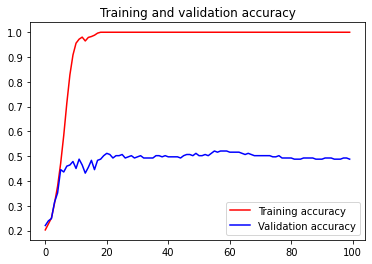

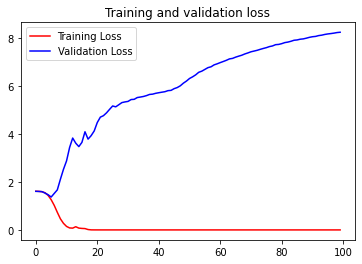

In [ ]:
## just run the bellow cell and see the acc and loss plots

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
def load_and_predict(model, path):
  '''
  This function is used to generate the models predictions on test data

  If you loaded your data in other way please change the function to produce your predictions correctly

  If not, just run the cell
  '''
  test_generator = ImageDataGenerator(rescale=1. / 255)

  test_iterator = test_generator.flow_from_directory(
        path,
        target_size=(224, 224),
        shuffle=False,
        class_mode='categorical',
        batch_size=1) 

  ids = []
  for filename in test_iterator.filenames:
    print(filename)
    ids.append(filename)

  predict_result = model.predict(test_iterator, steps=len(test_iterator.filenames))
  predictions = []
  for index, prediction in enumerate(predict_result):
    classes = np.argmax(prediction)
    predictions.append([ids[index], classes])
  predictions.sort()

  return predictions

In [10]:
def store_prediction(model_path, test_data_path, result_path):
  '''
  A function to run the load and predict function

  just run the cell
  '''
  model = keras.models.load_model(model_path, compile = True)

  predictions = load_and_predict(model, test_data_path)

  df = pd.DataFrame(data=predictions, columns=['image_id', 'label'])
  df = df.set_index(['image_id'])

  print(df.head())
  print('Writing submission')
  df.to_csv(result_path)

In [ ]:
store_prediction('my_own_model.h5', './test', './results.csv')

Found 209 images belonging to 5 classes.
iranKhodro_dena/iranKhodro_dena_109.jpg
iranKhodro_dena/iranKhodro_dena_12.jpg
iranKhodro_dena/iranKhodro_dena_120.jpg
iranKhodro_dena/iranKhodro_dena_128.jpg
iranKhodro_dena/iranKhodro_dena_140.jpg
iranKhodro_dena/iranKhodro_dena_146.jpg
iranKhodro_dena/iranKhodro_dena_160.jpg
iranKhodro_dena/iranKhodro_dena_163.jpg
iranKhodro_dena/iranKhodro_dena_189.jpg
iranKhodro_dena/iranKhodro_dena_197.jpg
iranKhodro_dena/iranKhodro_dena_211.jpg
iranKhodro_dena/iranKhodro_dena_24.jpg
iranKhodro_dena/iranKhodro_dena_245.jpg
iranKhodro_dena/iranKhodro_dena_271.jpg
iranKhodro_dena/iranKhodro_dena_281.jpg
iranKhodro_dena/iranKhodro_dena_3.jpg
iranKhodro_dena/iranKhodro_dena_304.jpg
iranKhodro_dena/iranKhodro_dena_31.jpg
iranKhodro_dena/iranKhodro_dena_318.jpg
iranKhodro_dena/iranKhodro_dena_319.jpg
iranKhodro_dena/iranKhodro_dena_329.jpg
iranKhodro_dena/iranKhodro_dena_356.jpg
iranKhodro_dena/iranKhodro_dena_37.jpg
iranKhodro_dena/iranKhodro_dena_370.jpg
iranK

Here your own CNN model implementation has done

## **Transfer learning from a pre-trained model**

This implementation is as the same to the previous one except in the model creation and training sections

So use the other ones for code simplicity 

In [11]:
def create_cnn_model():
    from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
    '''
    In this function you need to implement a cnn model from pre-trained one

    We recommand use the MobileNetV2 network

    See the bellow link:

    https://keras.io/api/applications/mobilenet/

    don't forget to fine-tune the last layer

    Use the imagenet weights

    '''
    #####################################
    ##### Your implementation here ######

    conv_base = MobileNetV2(include_top=False,
                            input_shape=(224, 224, 3),
                            weights='imagenet')
    conv_base.summary()

    model = Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()

    conv_base.trainable = False

    model.summary()

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=BATCH_SIZE
    )
    
    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=BATCH_SIZE
    )

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(train_generator,
              epochs=20,
              validation_data=validation_generator)
    
    conv_base.trainable = True
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block16_expand':
            set_trainable = True

        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.summary()
    #####################################
    return model

In [12]:
## train the model but don't forget adapte the hyper-parameters

history=train_model_naive_split()

Found 1680 images belonging to 5 classes.
Found 213 images belonging to 5 classes.
9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  

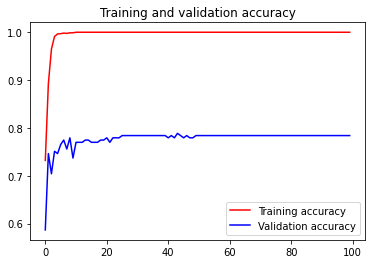

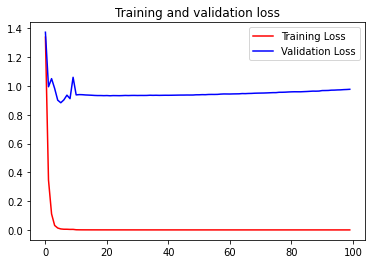

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
store_prediction('my_own_model.h5', './test', './results.csv')

Found 209 images belonging to 5 classes.
iranKhodro_dena/iranKhodro_dena_1.jpg
iranKhodro_dena/iranKhodro_dena_102.jpg
iranKhodro_dena/iranKhodro_dena_103.jpg
iranKhodro_dena/iranKhodro_dena_114.jpg
iranKhodro_dena/iranKhodro_dena_136.jpg
iranKhodro_dena/iranKhodro_dena_145.jpg
iranKhodro_dena/iranKhodro_dena_158.jpg
iranKhodro_dena/iranKhodro_dena_16.jpg
iranKhodro_dena/iranKhodro_dena_165.jpg
iranKhodro_dena/iranKhodro_dena_177.jpg
iranKhodro_dena/iranKhodro_dena_179.jpg
iranKhodro_dena/iranKhodro_dena_188.jpg
iranKhodro_dena/iranKhodro_dena_193.jpg
iranKhodro_dena/iranKhodro_dena_204.jpg
iranKhodro_dena/iranKhodro_dena_22.jpg
iranKhodro_dena/iranKhodro_dena_221.jpg
iranKhodro_dena/iranKhodro_dena_235.jpg
iranKhodro_dena/iranKhodro_dena_239.jpg
iranKhodro_dena/iranKhodro_dena_268.jpg
iranKhodro_dena/iranKhodro_dena_270.jpg
iranKhodro_dena/iranKhodro_dena_280.jpg
iranKhodro_dena/iranKhodro_dena_291.jpg
iranKhodro_dena/iranKhodro_dena_294.jpg
iranKhodro_dena/iranKhodro_dena_300.jpg
ira

## **Grad-CAM**
For some random images from different classes, show the heatmaps based on the grad-cam algorithm that you have learned.